In [33]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, '../python/pyecca')
from pyecca.lie import so3

import casadi as ca

def derive_equations():
    arm_angles_deg = [45, -135, -45, 135]
    motor_dirs = [1, 1, -1, -1]
    
    mix_matrix = ca.DM([
        # roll, pitch, yaw, thrust
        [   -1,     1,   1,     1], # duty motor 0
        [    1,    -1,   1,     1], # duty motor 1
        [    1,     1,  -1,     1], # duty motor 2
        [   -1,    -1,  -1,     1], # duty motor 3
    ])
        
    # state
    omega_b = ca.SX.sym('omega_b', 3)
    v_b = ca.SX.sym('v_b', 3)
    p_n = ca.SX.sym('p_n', 3)
    r_nb = ca.SX.sym('r_nb', 4)
    duty = ca.SX.sym('duty', 4)

    x = ca.vertcat(omega_b, v_b, r_nb, p_n, duty)
    x0 = [0]*17
    
    x_names = ['P', 'Q', 'R', 'U', 'V', 'W', 'r0', 'r1', 'r2', 'r3', 'x', 'y', 'z', 'duty0', 'duty1', 'duty2', 'duty3']
    x_id = {name: i for i, name in enumerate(x_names)}

    # input
    n_motors = len(arm_angles_deg)
    u = ca.SX.sym('u', 4)
    duty_cmd = ca.mtimes(mix_matrix, u)
    
    # parameters
    l_arm = ca.SX.sym('l_arm')
    m = ca.SX.sym('m')
    rho = ca.SX.sym('rho')
    Jx = ca.SX.sym('Jx')
    Jy = ca.SX.sym('Jy')
    Jz = ca.SX.sym('Jz')
    CT = ca.SX.sym('CT')
    CM = ca.SX.sym('CM')
    kV = ca.SX.sym('kV')
    vBatt = ca.SX.sym('vBatt')
    r_prop = ca.SX.sym('r_prop')
    g = ca.SX.sym('g')
    tau = ca.SX.sym('tau')
    p = ca.vertcat(l_arm, m, kV, vBatt, rho, Jx, Jy, Jz, CT, CM, r_prop, g, tau)
    p0 = [1, 1, 1550, 11.1, 1.225, 1, 1, 1, 2.7e-4, 5e-5, 0.1778/2, 9.8, 0.015]

    # build up
    J = ca.diag(ca.vertcat(Jx, Jy, Jz))

    # motor model
    def motor_model(duty, motor_dir):
        omega = duty*vBatt*kV*(2*ca.pi/60)
        V = r_prop*duty*vBatt*kV 
        s = ca.pi*r_prop**2
        q = rho*V**2/2
        return ca.vertcat(0, 0, -CT*q*s), ca.vertcat(0, 0, motor_dir*CM*q*s)

    # forces and moments
    C_nb = so3.Dcm.from_mrp(r_nb)
    F_b = ca.mtimes(C_nb.T, ca.vertcat(0, 0, m*g))
    M_b = ca.SX.zeros(3)
    for i in range(n_motors):
        arm_angle = arm_angles_deg[i]*ca.pi/180
        ri_b = ca.vertcat(l_arm*ca.cos(arm_angle), l_arm*ca.sin(arm_angle), 0)
        Fi_b, Mi_b = motor_model(duty_cmd[i], motor_dirs[i])
        F_b += Fi_b
        M_b += Mi_b + ca.cross(ri_b, Fi_b)

    x_dot = ca.vertcat(
        ca.mtimes(ca.inv(J), M_b - ca.cross(omega_b, ca.mtimes(J, omega_b))),
        F_b/m - ca.cross(omega_b, v_b),
        so3.Mrp.kinematics(r_nb, omega_b),
        ca.mtimes(C_nb, v_b),
        (duty_cmd - duty)/tau
    )
    
    # controller
    roll_cmd = 0.2
    pitch_cmd = 0.2
    yaw_cmd = 0.2

    kp_roll = 4
    kp_rollr = 0.2

    kp_yaw = 1
    kp_yawr = 0.2

    kp_pitch = kp_roll
    kp_pitchr = kp_rollr
    
    kp_climb = 0.5
    
    
    u_control = ca.SX.zeros(4)
    
    r_nb_cmd = so3.Mrp.from_euler(ca.vertcat(roll_cmd, pitch_cmd, yaw_cmd))
    e_theta = so3.Mrp.log(so3.Mrp.product(r_nb_cmd, so3.Mrp.inv(r_nb)))
    
    rollr_cmd = kp_roll*e_theta[0]
    roll_mix = kp_rollr*(rollr_cmd - omega_b[0])
    
    pitchr_cmd = kp_pitch*e_theta[1]
    pitch_mix = kp_pitchr*(pitchr_cmd - omega_b[1])
    
    yawr_cmd = kp_yaw*e_theta[2]
    yaw_mix = kp_yawr*(yawr_cmd - omega_b[2])
    
    

    u_control[0] = roll_mix
    u_control[1] = pitch_mix
    u_control[2] = yaw_mix
    u_control[3] = 0.515
    control = ca.Function('control', [x, p], [u_control], ['x', 'p'], ['u'])
    
    rhs = ca.Function('rhs', [x, u, p], [x_dot], ['x', 'u', 'p'], ['x_dot'])
    shadow_if_necessary = ca.Function('shadow_if_necessary', [r_nb], [so3.Mrp.shadow_if_necessary(r_nb)], ['r_nb'], ['r2_nb'])
    
    mrp_to_euler = ca.Function('mrp_to_euler', [r_nb], [so3.Euler.from_mrp(r_nb)], ['r_nb'], ['euler'])
    
    x_sat = ca.SX(x)
    for i in range(4):
        v = x_sat[i + 13]
        v = ca.if_else(v > 1, 1, ca.if_else(v < 0, 0, v))
        x_sat[i + 13] = v
    saturate = ca.Function('saturate', [x], [x_sat], ['x'], ['x_sat'])
    return locals()

eqs = derive_equations()

## Simulation

In [34]:
import scipy.integrate

def simulate(eqs, dt, tf):
    eqs = derive_equations()
    x0 = eqs['x0']
    p0 = eqs['p0']
    t_vect = np.arange(0, tf, dt)
    xi = x0
    data = {
        't': [],
        'x': [],
        'u': [],
        'euler': [],
    }
    for t in t_vect:
        u = np.array(eqs['control'](xi, p0)).reshape(-1)

        data['x'].append(xi)
        data['u'].append(u)
        data['t'].append(t)
        data['euler'].append(np.array(eqs['mrp_to_euler'](xi[6:10])).reshape(-1))
        
        res = scipy.integrate.solve_ivp(fun=lambda t, x: np.array(eqs['rhs'](xi, u, p0)).reshape(-1), t_span=[t, t+dt], t_eval=[t+dt], y0=xi)
        xi = res['y']
        xi[6:10] = eqs['shadow_if_necessary'](xi[6:10])
        xi = eqs['saturate'](xi)
        xi = np.array(xi).reshape(-1)

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

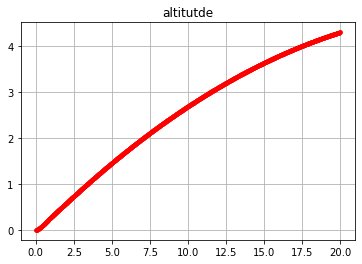

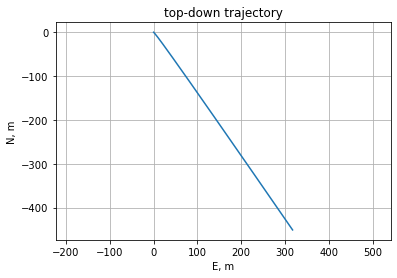

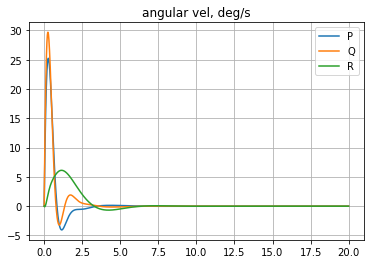

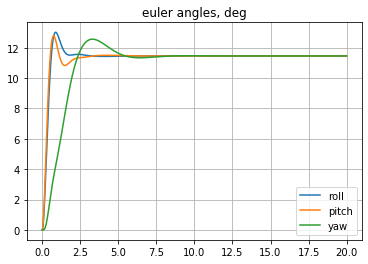

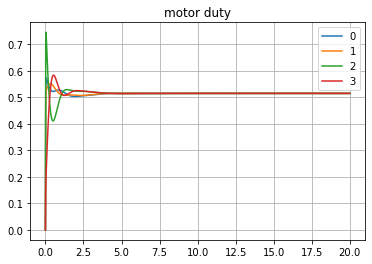

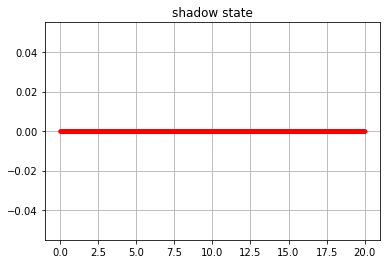

In [36]:
data = simulate(eqs, dt=0.01, tf=20)

plt.figure()
plt.plot(data['t'], -data['x'][:, eqs['x_id']['z']], 'r.')
plt.title('altitutde')
plt.grid()

plt.figure()
plt.plot(data['x'][:, eqs['x_id']['y']], data['x'][:, eqs['x_id']['x']])
plt.title('top-down trajectory')
plt.xlabel('E, m')
plt.ylabel('N, m')
plt.axis('equal')
plt.grid()

plt.figure()
plt.plot(data['t'], np.rad2deg(data['x'][:, eqs['x_id']['P']]), label='P')
plt.plot(data['t'], np.rad2deg(data['x'][:, eqs['x_id']['Q']]), label='Q')
plt.plot(data['t'], np.rad2deg(data['x'][:, eqs['x_id']['R']]), label='R')
plt.legend()
plt.title('angular vel, deg/s')
plt.grid()

plt.figure()
plt.plot(data['t'], np.rad2deg(data['euler'][:, 0]), label='roll')
plt.plot(data['t'], np.rad2deg(data['euler'][:, 1]), label='pitch')
plt.plot(data['t'], np.rad2deg(data['euler'][:, 2]), label='yaw')
plt.legend()
plt.title('euler angles, deg')
plt.grid()

plt.figure()
plt.plot(data['t'], data['x'][:, eqs['x_id']['duty0']], label='0')
plt.plot(data['t'], data['x'][:, eqs['x_id']['duty1']], label='1')
plt.plot(data['t'], data['x'][:, eqs['x_id']['duty2']], label='2')
plt.plot(data['t'], data['x'][:, eqs['x_id']['duty3']], label='3')
plt.legend()
plt.title('motor duty')
plt.grid()

plt.figure()
plt.plot(data['t'], data['x'][:, eqs['x_id']['r3']], 'r.')
plt.title('shadow state')
plt.grid()